In [2]:
import os
import pathlib
import pickle
import random
import collections

from glob import glob

import librosa
import matplotlib.pyplot as plt
import numpy as np
import opensmile
# import openl3
import seaborn as sns
import sklearn
import soundfile as sf

# from cyvlfeat.fisher import fisher
# from cyvlfeat.gmm import gmm

import torch
import torch.nn.functional as F
import torchaudio

import tensorflow_hub as hub
import tensorflow as tf

# import hearbaseline

from pydub import AudioSegment
from pytorch_lightning.utilities.seed import seed_everything
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.model_selection import cross_val_score, GroupKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
# from umap import UMAP

from byol_a.common import load_yaml_config
from byol_a.augmentations import PrecomputedNorm
from byol_a.models.audio_ntt import AudioNTT2020
from byol_a.models.cvt import CvT
from byol_a.models.resnetish import resnetish34

from serab_byols.utils import *

# Constants

_COG1_LOAD_PATH = '/home/gelbanna/hdd/data-backup/CogLoadv1/'
_COG2_LOAD_PATH = '/home/gelbanna/hdd/data-backup/CogLoadv2/'
_PHY_LOAD_PATH = '/home/gelbanna/hdd/data-backup/PhyLoad/PhyLoad_utterances'
_Multimodal_LOAD_PATH = '/home/gelbanna/hdd/audio_visual_stress_data'
_N_SPLITS = 5
_RANDOM_STATE = 42
_REQUIRED_SAMPLE_RATE = 16000
_SAMPLES_PER_SPEAKER = 40
_SCORING = 'recall_macro'  # Macro-average F1 score
_TSNE_PERPLEXITY = 20  # TSNE
_UMAP_N_NEIGHBORS = 5  # UMAP

tf.random.set_seed(_RANDOM_STATE)
seed_everything(_RANDOM_STATE)

Global seed set to 42


42

## Helper functions

In [52]:
def load_model_note(model_name, cfg, device):
    """Load pre-trained DL models.

    Parameters
    ----------
    model_name : str
        Model name
    cfg : EasyDict object
        Configuration details from config.yaml
    device : torch.device object
        Used device (CPU or GPU)

    Returns
    -------
    torch.nn.Module object or a tensorflow "trackable" object
        Model loaded with pre-training weights

    Raises
    ------
    ValueError
        If the model configuration is erroneous
        N.B. A PyTorch model should be loaded with pre-trained weights
    """
    weight_file = None

    # Load pretrained weights.
    if model_name == 'default':
        model = AudioNTT2020(n_mels=cfg.n_mels, d=cfg.feature_d)
        # print(model)

        if cfg.feature_d == 2048:
            weight_file = '/home/gelbanna/hdd/checkpoints/default2048_BYOLAs64x96-2105311814-e100-bs256-lr0003-rs42.pth'  # Retrained model
            # weight_file = 'checkpoints/AudioNTT2020-BYOLA-64x96d2048.pth'  # Pretrained model (original version)
            # weight_file = '/home/gelbanna/checkpoints/default2048OpenSmile5_BYOLAs-2110092152-e100-bs256-lr0003-rs42-augsequential.pth'
        elif cfg.feature_d == 1024:
            weight_file = 'checkpoints/default1024_BYOLAs64x96-2107292000-e100-bs256-lr0003-rs42.pth'  # Retrained model
            # weight_file = 'pretrained_weights/AudioNTT2020-BYOLA-64x96d1024.pth'  # Pretrained model (original version)
        elif cfg.feature_d == 512:
            weight_file = 'checkpoints/default512_BYOLAs64x96-2107281850-e100-bs256-lr0003-rs42.pth'  # Retrained model
            # weight_file = 'pretrained_weights/AudioNTT2020-BYOLA-64x96d512.pth'  # Pretrained model (original version)
        else:
            raise ValueError(f'{model_name} config not found for embedding dimension = {cfg.feature_d}. Try feature_d = 512, 1024 or 2048.')

    elif model_name == 'resnetish34':
        model = resnetish34()
        weight_file = 'checkpoints/resnetish34_BYOLAs64x96-2105271915-e100-bs256-lr0003-rs42.pth'

    elif model_name == 'cvt':
        s1_depth, s2_depth, s3_depth = cfg.depths
        s1_emb_dim, s2_emb_dim, s3_emb_dim = cfg.embed_dims
        s1_mlp_mult, s2_mlp_mult, s3_mlp_mult = cfg.mlp_mults

        model = CvT(
            s1_emb_dim=s1_emb_dim,
            s1_depth=s1_depth,
            s1_mlp_mult=s1_mlp_mult,
            s2_emb_dim=s2_emb_dim,
            s2_depth=s2_depth,
            s2_mlp_mult=s2_mlp_mult,
            s3_emb_dim=s3_emb_dim,
            s3_depth=s3_depth,
            s3_mlp_mult=s3_mlp_mult,
            pool=cfg.cvt_pool
        )

        if (s1_depth == 1) & (s2_depth == 2) & (s3_depth == 5):
            if cfg.embed_dims == [64, 128, 256]:
                weight_file = 'checkpoints/cvt_s1-d1_s2-d2_s3-d5_BYOLAs64x96-2106260817-e100-bs512-lr0003-rs42.pth'  # CvT 1-2-5 (64-128-256)
            else:
                raise ValueError(f'{model_name} config not found for depths = {cfg.depths}.')
        elif (s1_depth == 1) & (s2_depth == 1) & (s3_depth == 1):
            if (s2_emb_dim == 128) & (s3_emb_dim == 256):
                if cfg.shape == [64, 96]:
                    weight_file = 'checkpoints/cvt_s1-d1_s2-d1_s3-d1_BYOLAs64x96-2106251634-e100-bs512-lr0003-rs42.pth'  # CvT 1-1-1 (64-128-256)
                elif cfg.shape == [64, 144]:
                    # CvT 1-1-1 (64-128-256), but trained with 64x144 input (default: 64x96)
                    weight_file = 'checkpoints/cvt_s1-d1-e64_s2-d1-e128_s3-d1-e256_BYOLAs64x144-2107041557-e100-bs512-lr0003-rs42.pth'
                else:
                    raise ValueError(f'{model_name} config not found for depths = {cfg.depths} and embedding dimensions = {cfg.embed_dims}.')
            elif (s2_emb_dim == 192) & (s3_emb_dim == 384):
                weight_file = 'checkpoints/cvt_s1-d1-e64_s2-d1-e192_s3-d1-e384_BYOLAs64x96-2107011201-e100-bs512-lr0003-rs42.pth'
            elif (s2_emb_dim == 256) & (s3_emb_dim == 512):
                weight_file = 'checkpoints/cvt_s1-d1-e64_s2-d1-e256_s3-d1-e512_BYOLAs64x96-2107021643-e100-bs512-lr0003-rs42.pth'
                if cfg.cvt_pool == 'mean+max':
                    # CvT 1-1-1 (64-256-512), but trained with mean+max temporal aggregation technique from BYOL-A (--> embedding size: 2048)
                    weight_file = 'checkpoints/cvt_s1-d1-e64_s2-d1-e256_s3-d1-e512_BYOLAs64x96-2107301623-e100-bs256-lr0003-rs42.pth'
                else:
                    weight_file = 'checkpoints/cvt_s1-d1-e64_s2-d1-e256_s3-d1-e512_BYOLAs64x96-2107021643-e100-bs512-lr0003-rs42.pth'
        else:
            raise ValueError(f'{model_name} config not found.')
    elif model_name == 'vggish':
        model = hub.load('https://tfhub.dev/google/vggish/1')
    elif model_name == 'yamnet':
        model = hub.load('https://tfhub.dev/google/yamnet/1')
    elif model_name == 'trill':
        model = hub.load('https://tfhub.dev/google/nonsemantic-speech-benchmark/trill/3')
    elif model_name == 'openl3':
        model = openl3.models.load_audio_embedding_model(input_repr="mel256", content_type="env", embedding_size=6144)
    else:
        raise ValueError('Model not found.')

    if weight_file is not None:
        state_dict = torch.load(weight_file, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)

        # Disable parameter tuning
        model.eval()
        for param in model.parameters():
            param.requires_grad = False

    return model, weight_file

def compute_norm_stats(files):
    mean = 0.
    std = 0.

    for file in tqdm(files, desc=f'Computing stats...', total=len(files)):
        audio, orig_sr = sf.read(file) 
        
        # Convert to float if necessary
        if np.issubdtype(audio.dtype, np.integer):
            float_audio = audio.astype(np.float32) / np.iinfo(np.int16).max
        elif audio.dtype == np.float64:
            float_audio = np.float32(audio)
        else:
            float_audio = audio

        # Resample if needed
        if orig_sr != _REQUIRED_SAMPLE_RATE:
            float_audio = librosa.core.resample(
                float_audio,
                orig_sr=orig_sr,
                target_sr=_REQUIRED_SAMPLE_RATE,
                res_type='kaiser_best'
            )

        # Convert to tensor
        float_audio = torch.tensor(float_audio).unsqueeze(0)

        # Compute log-mel-spectrogram
        lms = (to_melspec(float_audio) + torch.finfo(torch.float).eps).log()

        # Compute mean, std
        mean += lms.mean()
        std += lms.std()

    mean /= len(files)
    std /= len(files)

    stats = [mean.item(), std.item()]

    print(f'Finished')

    return stats

def _generate_embeddings(
    model,
    model_name,
    files,
    to_melspec,
    normalizer,
    device
):
    """
    Generate audio embeddings from a pretrained feature extractor.

    Converts audios to float, resamples them to the desired learning_rate,
    and produces the embeddings from a pre-trained model.

    Adapted from https://github.com/google-research/google-research/tree/master/non_semantic_speech_benchmark

    Parameters
    ----------
    model : torch.nn.Module object or a tensorflow "trackable" object
        Model loaded with pre-training weights
    model_name : str
        Name of the model
    audios : list
        List of audios, loaded as a numpy arrays
    split : str
        Dataset split, can be 'train', 'validation' or 'test'.
    orig_sr : int
        Original sample rate in the dataset.
    to_melspec : torchaudio.transforms.MelSpectrogram object
        Mel-spectrogram transform to create a spectrogram from an audio signal
    normalizer : nn.Module
        Pre-normalization transform
    device : torch.device object
        Used device (CPU or GPU)

    Returns
    ----------
    embeddings: numpy.ndarray
        2D Array of embeddings for each audio of size (N, M). N = number of samples, M = embedding dimension
    """
    embeddings = []
    for file in tqdm(files, desc=f'Generating embeddings..', total=len(files), ascii=True):
        audio, orig_sr = sf.read(file) 
        
        # Convert to float if necessary
        if np.issubdtype(audio.dtype, np.integer):
            float_audio = audio.astype(np.float32) / np.iinfo(np.int16).max
        elif audio.dtype == np.float64:
            float_audio = np.float32(audio)
        else:
            float_audio = audio

        # Resample if needed
        if orig_sr != _REQUIRED_SAMPLE_RATE:
            float_audio = librosa.core.resample(
                float_audio,
                orig_sr=orig_sr,
                target_sr=_REQUIRED_SAMPLE_RATE,
                res_type='kaiser_best'
            )
        float_audio = float_audio[:int(_REQUIRED_SAMPLE_RATE*20)]
        if model_name == 'trill':
            embedding = np.mean(model(float_audio, sample_rate=_REQUIRED_SAMPLE_RATE)['layer19'], axis=0, keepdims=True)

        elif model_name == 'vggish':
            if len(float_audio) < _REQUIRED_SAMPLE_RATE:
                to_pad = _REQUIRED_SAMPLE_RATE - len(float_audio)
                pre_pad = np.random.randint(0, to_pad)
                post_pad = to_pad - pre_pad
                assert pre_pad + post_pad == to_pad

                float_audio = np.pad(float_audio, (pre_pad, post_pad))

            if model(float_audio).shape[0] == 0:
                print(float_audio.shape, float_audio.min(), float_audio.max())
                assert False
            embedding = np.mean(model(float_audio), axis=0, keepdims=True)

        elif model_name == 'yamnet':
            _, embedding, _ = model(float_audio)
            embedding = np.mean(embedding, axis=0, keepdims=True)
        
        elif model_name == 'openl3':
            embedding, _ = openl3.get_audio_embedding(float_audio, _REQUIRED_SAMPLE_RATE, model=model)
            embedding = np.mean(embedding, axis=0, keepdims=True)

        else:
            float_audio = torch.tensor(float_audio).unsqueeze(0)
            lms = normalizer((to_melspec(float_audio) + torch.finfo(torch.float).eps).log()).unsqueeze(0)
            embedding = model(lms.to(device)).cpu().detach().numpy()

        embeddings.append(embedding)

    print(f'Finished')
    embeddings = np.squeeze(np.array(embeddings, dtype=np.float32), 1)
    return embeddings

def _generate_byolsnew_embeddings(audios, model, device):
    embeddings = []
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    for file in tqdm(audios, desc=f'Generating embeddings..', total=len(audios), ascii=True):
        os_embeddings = smile.process_file(file).to_numpy().flatten()
        input_to_net = torch.tensor(os_embeddings).unsqueeze(0)
        input_to_net = input_to_net.reshape((1,1, 6373))
        embedding = model(input_to_net.to(device)).cpu().detach().numpy()
        embeddings.append(embedding)
    print(f'Finished')
    embeddings = np.squeeze(np.array(embeddings, dtype=np.float32), 1)
    return embeddings

def _get_sklearn_models():
    """
    Load a family of standard ML classifiers as a dictionary.

    Adapted from https://github.com/google-research/google-research/tree/master/non_semantic_speech_benchmark

    Current models: Logistic Regression, LDA, Random Forests

    Returns
    ----------
    dict
        A dictionary of ML classifiers
        key = model name, value = model (a scikit-learn Estimator)
    """
    return {
        # 'Logistic_Regression': lambda: LogisticRegression(random_state=_RANDOM_STATE),
        # 'LogisticRegression_balanced': lambda: LogisticRegression(C=1e5, max_iter=1e4, solver='lbfgs', multi_class='multinomial', class_weight='balanced', random_state=_RANDOM_STATE),
        # 'LDA_AUTO': lambda: LinearDiscriminantAnalysis(shrinkage='auto'),
        # 'Random_Forest': lambda: RandomForestClassifier(random_state=_RANDOM_STATE),
        # 'Forest_unbalanced_100': lambda: RandomForestClassifier(class_weight=None, n_estimators=100, random_state=_RANDOM_STATE),
        'Support_vector_machine': lambda: SVC(random_state=_RANDOM_STATE, max_iter=1e6),
        # 'Support_vector_machine_rbf': lambda: SVC(C=0.01, max_iter=1e4, random_state=_RANDOM_STATE, kernel='rbf')
    }
    
def _get_grid_search_params(clf_name):
    if clf_name == 'Logistic_Regression':
        estimator__solver = ['lbfgs']
        estimator__penalty = ['l2']
        estimator__C = [1e5, 1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
        estimator__class_weight = [None, 'balanced']
        # define grid search
        grid = dict(estimator__solver=estimator__solver,estimator__penalty=estimator__penalty,
        estimator__C=estimator__C, estimator__class_weight=estimator__class_weight)
    elif clf_name == 'Random_Forest':
        estimator__n_estimators = [10, 100, 1000]
        estimator__class_weight = [None, 'balanced']
        # define grid search
        grid = dict(estimator__n_estimators=estimator__n_estimators, estimator__class_weight=estimator__class_weight)
    elif clf_name == 'Support_vector_machine':
        estimator__kernel = ['linear']
        estimator__C = [1e5, 1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
        # define grid search
        grid = dict(estimator__kernel=estimator__kernel,estimator__C=estimator__C)
    elif clf_name == 'LDA_AUTO':
        estimator__solver = ['lsqr']
        # define grid search
        grid = dict(estimator__solver=estimator__solver)
    return grid

def _compute_split_boundaries(split_probs, n_items):
    """Computes boundary indices for each of the splits in split_probs.
    Args:
      split_probs: List of (split_name, prob), e.g. [('train', 0.6), ('dev', 0.2),
        ('test', 0.2)]
      n_items: Number of items we want to split.
    Returns:
      The item indices of boundaries between different splits. For the above
      example and n_items=100, these will be
      [('train', 0, 60), ('dev', 60, 80), ('test', 80, 100)].
    """
    if len(split_probs) > n_items:
        raise ValueError('Not enough items for the splits. There are {splits} '
                         'splits while there are only {items} items'.format(splits=len(split_probs), items=n_items))
    total_probs = sum(p for name, p in split_probs)
    if abs(1 - total_probs) > 1E-8:
        raise ValueError('Probs should sum up to 1. probs={}'.format(split_probs))
    split_boundaries = []
    sum_p = 0.0
    for name, p in split_probs:
        prev = sum_p
        sum_p += p
        split_boundaries.append((name, int(prev * n_items), int(sum_p * n_items)))

    # Guard against rounding errors.
    split_boundaries[-1] = (split_boundaries[-1][0], split_boundaries[-1][1],
                            n_items)
    return split_boundaries

def split_audio(file, seconds):
    audio_chunks = []
    audio_splitter = []
    audio, orig_sr = sf.read(file)
    wavname = os.path.basename(file)

    # Convert to mono if needed
    if audio.ndim == 2:
        audio = np.expand_dims(np.mean(audio, axis=1), axis=0)
    else:
        audio = np.expand_dims(audio, axis=0)
        
    audio_len = audio.shape[1]
    # print(f'The audio {wavname} contains {audio_len/orig_sr} seconds')

    # Convert to float if necessary
    if np.issubdtype(audio.dtype, np.integer):
        float_audio = audio.astype(np.float32) / np.iinfo(np.int16).max
    elif audio.dtype == np.float64:
        float_audio = np.float32(audio)
    else:
        float_audio = audio

    # Split audio into chunks of X seconds as setted in args.sec (default = 3 sec)
    noSections = int(np.ceil(audio_len/orig_sr))
    try:
        for i in range(0, noSections, seconds):
            temp = np.squeeze(float_audio[:, i*orig_sr:i*orig_sr + seconds*orig_sr])
            audio_chunks.append(temp)
        audio_splitter.append(len(audio_chunks))
    except:
        print(f'The number of seconds in audio {wavname} is smaller than the splitting criteria ({seconds} sec)')
    return wavname, audio_chunks

def items_to_split_datasets(items_and_groups, split_probs, split_to_ids, sec):
    groups = sorted(set(gender_id+group_id for _, _, group_id, gender_id in items_and_groups))
    gender_id = {'F': list(filter(lambda k: 'F' in k, groups)),
                'M': list(filter(lambda k: 'M' in k, groups))}
    group_id_to_split = {}
    for gender in ['M', 'F']:
        split_boundaries = _compute_split_boundaries(split_probs, len(gender_id[gender]))
        for split_name, i_start, i_end in split_boundaries:
            for i in range(i_start, i_end):
                i = i - len(gender_id[gender])
                group_id_to_split[gender_id[gender][i]] = split_name
    # print(group_id_to_split)
    for item, label, group_id, gender_id in items_and_groups:
        split = group_id_to_split[gender_id+group_id]
        # wavname, audio_chunks = split_audio(item, sec)
        # for i in range(len(audio_chunks)):
        split_to_ids[split]['audio'].append(item)
        split_to_ids[split]['label'].append(label)
        split_to_ids[split]['id'].append(group_id)
        split_to_ids[split]['gender'].append(gender_id)
    # print(len(split_to_ids['train']['audio']), len(split_to_ids['test']['audio']))
    return split_to_ids

def _split_data(dataset_paths, sec=3, ratio=0.75):
    split_probs = [('train', ratio), ('test', 1-ratio)]
    split_to_ids = collections.defaultdict(lambda: collections.defaultdict(list))
    for i, data_dir in enumerate(dataset_paths):
        data = sorted(glob(f'{data_dir}/*_mono.wav'))
        if i == 2:
            data = sorted(glob(f'{data_dir}/*.wav'))
        names = list(map(os.path.basename, sorted(glob(data_dir))))
        speaker_ids = list(map(lambda x: pathlib.PurePath(x).parent.name, data))
        if i == 0:
            labels = list(map(_parse_label_for_cog1, data))
            genders = list(map(_parse_gender, data))
        elif i == 1:
            labels = list(map(_parse_label_for_cog2, data))
            genders = ['F'] * 400 + ['M'] * 400
        else:
            labels = list(map(_parse_label_for_phy, data))
            genders = list(map(_parse_gender_for_phy, data))
        
        items_and_groups = list(zip(data, labels, speaker_ids, genders))
        split_to_ids = items_to_split_datasets(items_and_groups, split_probs, split_to_ids, sec)
        print(f'Data {i+1}: {len(data)} samples, {len(names)} subjects.')
    return split_to_ids

def _eval_embeddings_grid_search(train_embeddings, train_labels, test_embeddings, test_labels, scoring):
    classifiers = _get_sklearn_models()

    for clf_name, val in classifiers.items():
        clf = val()
        grid = _get_grid_search_params(clf_name)
        cv = RepeatedStratifiedKFold(n_splits=_N_SPLITS, n_repeats=3, random_state=_RANDOM_STATE)
        pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', clf)])
        grid_search = GridSearchCV(pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring=_SCORING,error_score=0)
        grid_result = grid_search.fit(train_embeddings, train_labels)
        test_score = grid_result.score(test_embeddings, test_labels) 
        print(f'Best {clf_name} {scoring}: {grid_result.best_score_*100: .2f} using {grid_result.best_params_}')
        print(f'    Test {clf_name} {scoring}: {test_score*100: .2f}')

def _eval_embeddings(embeddings, labels, speaker_ids, scoring):
    classifiers = _get_sklearn_models()

    for clf_name, val in classifiers.items():
        clf = val()

        pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', clf)])
        cv_acc = cross_val_score(
            pipeline, 
            embeddings, 
            labels, 
            groups=speaker_ids,
            scoring=scoring,
            cv=GroupKFold(n_splits=_N_SPLITS)
        )
        print(f'{clf_name} 5-CV {scoring}: {100*cv_acc.mean():.1f}')
        
def _parse_label_for_cog1(file):
    key = os.path.splitext(os.path.basename(file))[0].replace('_mono', '')
    metadata_file = glob(f'{os.path.dirname(file)}/metadata*.pkl')[0]
    
    metadata = pickle.load(open(metadata_file,'rb'))
    
    syls = metadata[key]['syls']
    
    if syls == 0:
        try:
            assert(metadata[key]['block'] == 0)  # Sanity check
        except KeyError:
            assert(metadata[key]['step'] == 0)  # Sanity check
        return 'without'
    else:
        try:
            assert(metadata[key]['block'] > 0)  # Sanity check
        except KeyError:
            assert(metadata[key]['step'] > 0)  # Sanity check
        return 'with'

def _parse_label_for_cog2(file):
    if 'without' in file:
        return 'without'
    elif 'with' in file and not('without' in file):
        return 'with'
    else:
        raise ValueError

def _parse_label_for_phy(file):
    if 'after' in file:
        return 'with'
    elif 'before' in file:
        return 'without'
    else:
        raise ValueError

def _parse_gender(file):
    speaker_id = pathlib.PurePath(file).parent.name
    if speaker_id[0] == 'M':
        return 'M'
    elif speaker_id[0] == 'F':
        return 'F'
    else:
        raise ValueError('Gender [M/F] not found.')

def _parse_gender_for_phy(file):
    if 'sf' in file:
        return 'F'
    elif 'sm' in file:
        return 'M'
    else:
        raise ValueError

## Load configs and data

In [53]:
device = torch.device('cuda')
cfg = load_yaml_config('/home/gelbanna/hdd/cto-paralinguistics/recola_training/config.yaml')

In [5]:
data = [_COG1_LOAD_PATH+'/results/*/*', _COG2_LOAD_PATH+'/raw/*/*/*', _PHY_LOAD_PATH+'/*']
data_audios = _split_data(data, sec=4)

Data 1: 586 samples, 21 subjects.
Data 2: 800 samples, 20 subjects.
Data 3: 280 samples, 28 subjects.


In [6]:
audio_files = sorted(glob(f'{_Multimodal_LOAD_PATH}/*/*/*_mono.wav'))
names = list(map(os.path.basename, sorted(glob(f'{_Multimodal_LOAD_PATH}/*/*'))))
speaker_ids = list(map(lambda x: pathlib.PurePath(x).parent.name, audio_files))
labels = list(map(_parse_label_for_cog2, audio_files))
genders = ['F'] * 400 + ['M'] * 400

In [7]:
to_melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sample_rate,
    n_fft=cfg.n_fft,
    win_length=cfg.win_length,
    hop_length=cfg.hop_length,
    n_mels=cfg.n_mels,
    f_min=cfg.f_min,
    f_max=cfg.f_max,
)

## 0. Feature extraction

### 0.1 openSMILE

In [8]:
def _generate_opensmile_embeddings(files, all_features=True):
    opensmile_embeddings = []

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    for file in tqdm(files):
        embedding = smile.process_file(file).to_numpy().flatten()
        if np.isnan(embedding).any():
            embedding = np.nan_to_num(embedding)
            print(f"This Sample has nan in the embeddings")
        opensmile_embeddings.append(embedding)

    if not all_features:
        with open('common_features_with_grid_search.txt') as f:
            common_features = f.read().splitlines()
        features_set = smile.feature_names
        features_indicies = [features_set.index(common_features[i]) for i in range(len(common_features))]
        features_indicies.sort(reverse=False)
        opensmile_embeddings = np.array(opensmile_embeddings)[:, features_indicies]
    else:
        opensmile_embeddings = np.array(opensmile_embeddings)
        print('hello')

    # print(f'Embeddings shape {opensmile_embeddings.shape}')
    return opensmile_embeddings

In [8]:
train_opensmile_embeddings = _generate_opensmile_embeddings(data_audios['train']['audio'], all_features=True)
test_opensmile_embeddings = _generate_opensmile_embeddings(data_audios['test']['audio'], all_features=True)

  0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x7f3ad88f8af0>
Traceback (most recent call last):
  File "/home/gelbanna/miniconda3/envs/serab2/lib/python3.8/site-packages/opensmile/core/SMILEapi.py", line 362, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):
KeyboardInterrupt: 
/home/gelbanna/miniconda3/envs/serab2/lib/python3.8/site-packages/opensmile/core/smile.py:305: UserWarning: Segment too short, filling with NaN.
  warnings.warn(


This Sample has nan in the embeddings


### 0.2 Retrained Models

In [9]:
#Get the model name for this experiment based on config.yaml
model_name = 'default'

In [54]:
def _data_driven_embeddings(files, model_name, stats=None):
    # stats = [-5.7682881355285645, 4.009721755981445]
    # stats = None
    if stats is None:
        stats = compute_norm_stats(files)
        print(stats)

    normalizer = PrecomputedNorm(stats)

    model, weight_file = load_model_note(model_name, cfg, device)

    print(weight_file)
    return _generate_embeddings(model, model_name, files, to_melspec, normalizer, device)
    # return _generate_byolsnew_embeddings(files, model, device)

In [11]:
def generate_byols_embeddings(
    model,
    audios,
    to_melspec,
    normalizer,
    device):
    """
    Generate audio embeddings from a pretrained feature extractor.

    Converts audios to float, resamples them to the desired learning_rate,
    and produces the embeddings from a pre-trained model.

    Adapted from https://github.com/google-research/google-research/tree/master/non_semantic_speech_benchmark

    Parameters
    ----------
    model : torch.nn.Module object or a tensorflow "trackable" object
        Model loaded with pre-training weights
    audios : list
        List of audios, loaded as a numpy arrays
    to_melspec : torchaudio.transforms.MelSpectrogram object
        Mel-spectrogram transform to create a spectrogram from an audio signal
    normalizer : nn.Module
        Pre-normalization transform
    device : torch.device object
        Used device (CPU or GPU)

    Returns
    ----------
    embeddings: Tensor
        2D Array of embeddings for each audio of size (N, M). N = number of samples, M = embedding dimension
    """
    embeddings = []
    for audio in tqdm(audios):
        lms = normalizer((to_melspec(audio.to(device)) + torch.finfo(torch.float).eps).log()).unsqueeze(0)
        embedding = model(lms.to(torch.device('cpu')))
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

In [69]:
import torchaudio.transforms as T
# Default hop_size in milliseconds
TIMESTAMP_HOP_SIZE = 25
SCENE_HOP_SIZE = 250
BATCH_SIZE = 512
def get_audios(file):
    audio, sr = torchaudio.load(file)
    # resampler = T.Resample(sr, 16000, dtype=audio.dtype)
    # resampled_waveform = resampler(audio)
    # audios.append(audio)
    # audios = torch.cat(audios, dim=0)
    return audio[:, :int(20 * sr)]

def load_model_(model_file_path: str = "") -> torch.nn.Module:
    """Load pre-trained DL models.

    Parameters
    ----------


    Returns
    -------
    torch.nn.Module object or a tensorflow "trackable" object
        Model loaded with pre-training weights

    Raises
    ------
    ValueError
        If the model configuration is erroneous
        N.B. A PyTorch model should be loaded with pre-trained weights
    """
    # Load pretrained weights.
    # if model_name == 'byols':
    model = AudioNTT2020(n_mels=64, d=2048)
    
    state_dict = torch.load(model_file_path, map_location=torch.device('cuda'))
    model.load_state_dict(state_dict)
    return model

def get_timestamp_embeddings(
    audio,
    model,device,
    hop_size= TIMESTAMP_HOP_SIZE):
    """
    This function returns embeddings at regular intervals centered at timestamps. Both
    the embeddings and corresponding timestamps (in milliseconds) are returned.
    Args:
        audio: n_sounds x n_samples of mono audio in the range [-1, 1].
        model: Loaded model.
        hop_size: Hop size in milliseconds.
            NOTE: Not required by the HEAR API. We add this optional parameter
            to improve the efficiency of scene embedding.
    Returns:
        - Tensor: embeddings, A float32 Tensor with shape (n_sounds, n_timestamps,
            model.timestamp_embedding_size).
        - Tensor: timestamps, Centered timestamps in milliseconds corresponding
            to each embedding in the output. Shape: (n_sounds, n_timestamps).
    """
    
    # These attributes are specific to this baseline model
    n_fft = 4096
    win_length = 400
    hop_length = 160
    n_mels = 64
    f_min = 60
    f_max = 7800
    to_melspec = torchaudio.transforms.MelSpectrogram(
                        sample_rate=AudioNTT2020.sample_rate,
                        n_fft=n_fft,
                        win_length=win_length,
                        hop_length=hop_length,
                        n_mels=n_mels,
                        f_min=f_min,
                        f_max=f_max,
                        ).to(device)

    # Make sure the correct model type was passed in
    if not isinstance(model, AudioNTT2020):
        raise ValueError(
            f"Model must be an instance of {AudioNTT2020.__name__}"
        )

    # Send the model to the same device that the audio tensor is on.
    model = model.to(device)

    # Split the input audio signals into frames and then flatten to create a tensor
    # of audio frames that can be batch processed.
    frames, timestamps = frame_audio_(
        audio,
        frame_size=n_fft,
        hop_size=hop_size,
        sample_rate=AudioNTT2020.sample_rate,
    )
    audio_batches, num_frames, _ = frames.shape
    frames = frames.flatten(end_dim=1)

    melspec_frames = ((to_melspec(frames) + torch.finfo(torch.float).eps).log())
    normalizer = PrecomputedNorm(compute_stats(melspec_frames))
    melspec_frames = normalizer(melspec_frames).unsqueeze(0)
    melspec_frames = melspec_frames.permute(1, 0, 2, 3)
    
    # We're using a DataLoader to help with batching of frames
    dataset = torch.utils.data.TensorDataset(melspec_frames)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
    )

    # Put the model into eval mode, and not computing gradients while in inference.
    # Iterate over all batches and accumulate the embeddings for each frame.
    # Disable parameter tuning
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    with torch.no_grad():
        embeddings_list = [model(batch[0].to(torch.device('cpu'))) for batch in loader]
    #     embeddings_list = []
    #     for batch in loader:
    #         print(batch[0].shape)
    #         embeddings_list.append(model(batch[0]))

    # # # Concatenate mini-batches back together and unflatten the frames
    # # # to reconstruct the audio batches
    embeddings = torch.cat(embeddings_list, dim=0)
        # embeddings = model(melspec_frames)
    embeddings = embeddings.unflatten(0, (audio_batches, num_frames))

    return embeddings, timestamps

def compute_scene_stats(audios, to_melspec, device):
    mean = 0.
    std = 0.
    for audio in audios:
        # Compute log-mel-spectrogram
        lms = (to_melspec(audio.to(device)) + torch.finfo(torch.float).eps).log()

        # Compute mean, std
        mean += lms.mean()
        std += lms.std()

    mean /= len(audios)
    std /= len(audios)

    stats = [mean.item(), std.item()]
    return stats

def get_scene_embeddings(
    audio,
    model, device):
    """
    
    This function returns a single embedding for each audio clip. In this baseline
    implementation we simply summarize the temporal embeddings from
    get_timestamp_embeddings() using torch.mean().
    Args:
        audio: n_sounds x n_samples of mono audio in the range [-1, 1]. All sounds in
            a batch will be padded/trimmed to the same length.
        model: Loaded model.
    Returns:
        - embeddings, A float32 Tensor with shape
            (n_sounds, model.scene_embedding_size).
    """
    embeddings, _ = get_timestamp_embeddings(audio, model, device, hop_size=SCENE_HOP_SIZE)
    embeddings = torch.mean(embeddings, dim=1)
    # These attributes are specific to this baseline model
    # n_fft = 1024
    # win_length = 400
    # hop_length = 160
    # n_mels = 64
    # f_min = 60
    # f_max = 7800
    # to_melspec = torchaudio.transforms.MelSpectrogram(
    #                     sample_rate=AudioNTT2020.sample_rate,
    #                     n_fft=n_fft,
    #                     win_length=win_length,
    #                     hop_length=hop_length,
    #                     n_mels=n_mels,
    #                     f_min=f_min,
    #                     f_max=f_max,
    #                     ).to(device)
    # stats = compute_scene_stats(audio, to_melspec, device)
    # normalizer = PrecomputedNorm(stats)
    # embeddings = generate_byols_embeddings(model, audio, to_melspec, normalizer, device)
    return embeddings

In [70]:
def frame_audio_(
    audio, frame_size: int, hop_size: float, sample_rate: int
):
    """
    Adapted from https://github.com/neuralaudio/hear-baseline/hearbaseline/
    
    Slices input audio into frames that are centered and occur every
    sample_rate * hop_size samples. We round to the nearest sample.
    Args:
        audio: input audio, expects a 2d Tensor of shape:
            (n_sounds, num_samples)
        frame_size: the number of samples each resulting frame should be
        hop_size: hop size between frames, in milliseconds
        sample_rate: sampling rate of the input audio
    Returns:
        - A Tensor of shape (n_sounds, num_frames, frame_size)
        - A Tensor of timestamps corresponding to the frame centers with shape:
            (n_sounds, num_frames).
    """

    # Zero pad the beginning and the end of the incoming audio with half a frame number
    # of samples. This centers the audio in the middle of each frame with respect to
    # the timestamps.
    audio = F.pad(audio, (frame_size // 2, frame_size - frame_size // 2))
    num_padded_samples = audio.shape[1]

    frame_step = hop_size / 1000.0 * sample_rate
    frame_number = 0
    frames = []
    timestamps = []
    frame_start = 0
    frame_end = frame_size
    while True:
        frames.append(audio[:, frame_start:frame_end])
        timestamps.append(frame_number * frame_step / sample_rate * 1000.0)

        # Increment the frame_number and break the loop if the next frame end
        # will extend past the end of the padded audio samples
        frame_number += 1
        frame_start = int(round(frame_number * frame_step))
        frame_end = frame_start + frame_size

        if not frame_end <= num_padded_samples:
            break

    # Expand out the timestamps to have shape (n_sounds, num_frames)
    timestamps_tensor = torch.tensor(timestamps, dtype=torch.float32)
    timestamps_tensor = timestamps_tensor.expand(audio.shape[0], -1)

    return torch.stack(frames, dim=1), timestamps_tensor

In [63]:
file_path = '/home/gelbanna/hdd/serab_byols/checkpoints/default2048_BYOLAs64x96-2105311814-e100-bs256-lr0003-rs42.pth'
model = load_model_(file_path)
device = torch.device('cpu')
audios = []
for file in tqdm(audio_files):
    audios.append(get_audios(file))

100%|██████████| 800/800 [00:47<00:00, 16.77it/s]


In [71]:
audios[1].shape

torch.Size([1, 320000])

In [72]:
embeddings = get_scene_embeddings(torch.cat(audios).to(device), model, device)

In [66]:
embeddings.shape

torch.Size([800, 2048])

In [55]:
train_byols_embeddings = _data_driven_embeddings(audio_files, model_name)
# test_byols_embeddings = _data_driven_embeddings(data_audios['test']['audio'], model_name, stats=[-6.121060371398926, 4.023158073425293])

Computing stats...: 100%|██████████| 800/800 [00:13<00:00, 59.39it/s]


Finished
[-6.754568576812744, 3.627610445022583]


Generating embeddings..:   0%|          | 0/800 [00:00<?, ?it/s]

/home/gelbanna/hdd/checkpoints/default2048_BYOLAs64x96-2105311814-e100-bs256-lr0003-rs42.pth


/home/gelbanna/hdd/miniconda3/envs/serab/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Generating embeddings..: 100%|##########| 800/800 [00:09<00:00, 82.03it/s] 

Finished


In [40]:
train_byols_embeddings[0,:]

array([17.892359, 51.849792, 33.414135, ..., 52.52409 ,  0.      ,
       53.129322], dtype=float32)

## 1. Group analysis

### 1.1. A first unsupervised look

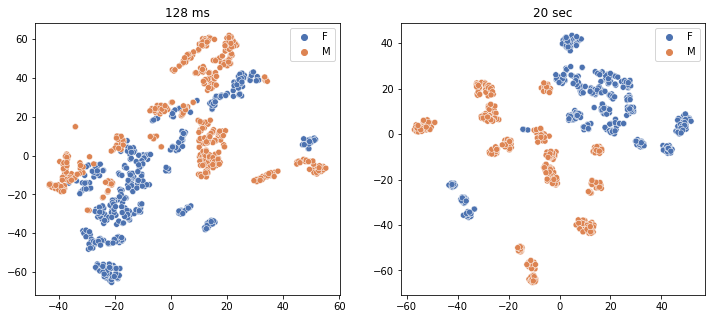

In [68]:
# Fit UMAP dimensionality reduction
# reducer = UMAP(n_components=2, random_state=_RANDOM_STATE, n_neighbors=_UMAP_N_NEIGHBORS, min_dist=0.1)
# umap_embeddings = reducer.fit_transform(StandardScaler().fit_transform(train_byols_embeddings))

# Fit TSNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=_RANDOM_STATE, perplexity=_TSNE_PERPLEXITY)
tsne_sub_embeddings = tsne.fit_transform(embeddings)
tsne_embeddings = tsne.fit_transform(train_byols_embeddings)

# Visualize dimension-reduced embeddings
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=tsne_sub_embeddings[:,0], y=tsne_sub_embeddings[:,1], hue=genders, palette='deep', ax=ax[0])
sns.scatterplot(x=tsne_embeddings[:,0], y=tsne_embeddings[:,1], hue=genders, palette='deep', ax=ax[1])
ax[0].set_title(f'128 ms')
ax[1].set_title(f'20 sec')
plt.show()

### 1.2. Supervised approach
* "Lazy" approach: 70-30 split (14-6 speakers, respecting gender balance)
    * Test set: 3 first females, 3 first males in alphabetical order
* "Robust" approach: 5-fold CV

_N.B: note that the dataset is completely balanced, so no real need for UAR/AUC metrics_

## Grid search for SVM classifiers.

In [15]:
_eval_embeddings_grid_search(train_opensmile_embeddings, data_audios['train']['label'], test_opensmile_embeddings, data_audios['test']['label'], scoring=_SCORING)

/home/gelbanna/miniconda3/envs/serab/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gelbanna/miniconda3/envs/serab/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gelbanna/miniconda3/envs/serab/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gelbanna/miniconda3/envs/serab/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gelbanna/miniconda3/envs/s

Best Support_vector_machine recall_macro:  70.76 using {'estimator__C': 0.001, 'estimator__kernel': 'linear'}
    Test Support_vector_machine recall_macro:  67.04


In [12]:
_eval_embeddings_grid_search(train_byols_embeddings, data_audios['train']['label'], test_byols_embeddings, data_audios['test']['label'], scoring=_SCORING)

Best Support_vector_machine recall_macro:  74.41 using {'estimator__C': 0.01, 'estimator__kernel': 'linear'}
    Test Support_vector_machine recall_macro:  68.67


In [11]:
_eval_embeddings_grid_search(train_hear_embeddings, data_audios['train']['label'], test_hear_embeddings, data_audios['test']['label'], scoring=_SCORING)

/home/gelbanna/miniconda3/envs/serab2/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/gelbanna/miniconda3/envs/serab2/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/gelbanna/miniconda3/envs/serab2/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/gelbanna/miniconda3/envs/serab2/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter

Best Support_vector_machine recall_macro:  78.22 using {'estimator__C': 0.1, 'estimator__kernel': 'linear'}
    Test Support_vector_machine recall_macro:  59.53
